In [ ]:
%matplotlib inline
import torch
import numpy as np
import os, cv2
from torchvision import models
import torchvision.transforms as T
from torch import nn
from torch.autograd import Variable
from PIL import Image
from pprint import pprint
import time
import math
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
from torch import optim
import torch.nn.functional as F
import random

In [ ]:
MAX_LENGTH = 200

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
Image_transform = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

In [ ]:
def get_path(s):
    paths = {
        "Images" : "data/images/",
        "Vocab" : "data/kaggle/cleaned_mathml/vocab.csv",
        "MathML" : "data/kaggle/cleaned_mathml/"
    }
    return paths[s]

In [ ]:
Image_file_names = os.listdir(get_path("Images"))
MathML_file_names = os.listdir(get_path("MathML"))

temp_image = []
temp_mm = []

for mm_name in set(MathML_file_names):
    img_name = mm_name[:-4] + ".inkml.png"
    if(img_name in Image_file_names):
        temp_image.append(img_name)
        temp_mm.append(mm_name)
        
Image_file_names = temp_image
MathML_file_names = temp_mm
data_size = len(Image_file_names)

In [ ]:
wordtoint = {
    '<SOS>' : 0
}
inttoword = {
    0 : '<SOS>',
}
with open(get_path("Vocab")) as f:
    words = f.read().strip().split(" ")
    for e, word in enumerate(words):
        wordtoint[word] = e+1
        inttoword[e+1] = word
end = len(wordtoint)
wordtoint['<EOS>'] = end
inttoword[end] = '<EOS>'
SOS_token = 0
EOS_token = end

In [ ]:
def get_input_pair(index, EOS_token=EOS_token):
    img = Image.fromarray(cv2.imread(get_path("Images") + Image_file_names[index]))
    img = Image_transform(img).unsqueeze(0)
    tar = None
    with open(get_path("MathML") + MathML_file_names[index]) as f:
        arr = f.read().strip().split(" ")
        tar = [torch.tensor([wordtoint[word]]) for word in arr]
    tar.append(torch.tensor([EOS_token]))
    tar = torch.tensor(tar).reshape(-1, 1)
    return img, tar

In [ ]:
img_data = None
mm_data = None
def get_input_pair_fast(index, img_data=img_data, mm_data=mm_data):
    if(img_data != None):
        return img_data[index], mm_data[index]
    img_data = []
    mm_data = []
    for k in range(len(Image_file_names)):
        a, b = get_input_pair(k)
        img_data.append(a)
        mm_data.append(b)
    return img_data[index], mm_data[index]

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        temp_model = models.densenet169(pretrained=True)
        modules = list(temp_model.children())[:-1]
        self.densenet = nn.Sequential(*modules)

        # It stops pytorch from precalulating gradients for pretrained model
        for p in self.densenet.parameters():
            p.requires_grad = False
        # (1, 1664, 7, 7)
        self.cnn1 = nn.Conv2d(1664, 1500, kernel_size=(1,1))
        self.cnn2 = nn.Conv2d(1500, 1400, kernel_size=(1,1))
        self.relu = nn.ReLU()

    def forward(self, image):
        # (1, 3, 224, 224)
        output = self.densenet(image)
        # (1, 1664, 7, 7)
        output = self.relu(self.cnn2(self.relu(self.cnn1(output))))
        # (1, 1400, 7, 7)
        # (200, 343)
        return output

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, drop_prob=0.1, max_size=MAX_LENGTH):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.drop_prob = drop_prob
        self.max_size = max_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_size)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(drop_prob)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, inp, hidden, encoder_outputs):
        embedded = self.embedding(inp).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         print(attn_weights.shape)
#         print(encoder_outputs.shape)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights
        # (1, 1, 5)
        # (1, 1, 1, 5)
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, valid=False, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(0)
#     print(input_tensor.shape)
#     print(target_tensor.shape)
#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    encoder_outputs = encoder(input_tensor).reshape(200, -1)
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
#     print(encoder_outputs.shape)
    
    decoder_hidden = decoder.initHidden()

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # print(target_tensor[di], decoder_output)
            loss += criterion(decoder_output, target_tensor[di])
            
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder( decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    if(not valid):
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=5, learning_rate=0.001, e_start=1):
    start = time.time()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    encoder_optimizer = optim.SGD([{"params" : encoder.cnn1.parameters()},
                                   {"params" : encoder.cnn2.parameters()}]
                                  , lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    train_losses = []
    valid_losses = []
    last_valid_loss = None
    data_index = list(range(data_size))
    train_data_index = data_index[ : int(data_size*0.9)]
    validation_data_index = data_index[int(data_size*0.9):]
    if(len(train_data_index) + len(validation_data_index) != data_size):
        print("partition Is Not Good Dude!!")
        return
    for i in range(e_start, n_iters + 1):
        random.shuffle(train_data_index)
        total_loss = 0
        encoder = encoder.train()
        decoder = decoder.train()
        for k in train_data_index:
            input_tensor, target_tensor = get_input_pair(k)
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)
            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            total_loss += loss

        loss_avg = total_loss/len(train_data_index)
        print('%s (%d %d%%) %.4f' % (timeSince(start, i / n_iters), i, i / n_iters * 100, loss_avg))
        train_losses.append(loss_avg)
        
        valid_loss = 0
        encoder = encoder.eval()
        decoder = decoder.eval()
        for k in validation_data_index:
            input_tensor, target_tensor = get_input_pair(k)
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)
            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, valid=True)
            valid_loss += loss

        avg_valid_loss = valid_loss/len(validation_data_index)
        valid_losses.append(avg_valid_loss)

        if(last_valid_loss == None or (avg_valid_loss < last_valid_loss)):
            last_valid_loss = avg_valid_loss
            print(f'Saving Model at Epoch: {i} with validation loss {avg_valid_loss}')
            save_state(i, encoder, encoder_optimizer, decoder, decoder_optimizer, avg_valid_loss)
    showPlot(train_losses, valid_losses, 'red')

In [ ]:
def showPlot(points1, points2, color):
    %matplotlib inline
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points1, color='red')
    plt.plot(points2, color='blue')

In [ ]:
# showPlot([1, 2, 3])

In [ ]:
def save_state(epoch, encoder, encoder_optimizer, decoder, decoder_optimizer, loss):
    torch.save({
            'epoch': epoch,
            'loss' : loss,
            'encoder_state_dict': encoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
            }, "checkpoint" + str(epoch) + ".pth")

In [ ]:
# hidden_size = 256
# encoder1 = Encoder().to(device)
# attn_decoder1 = AttnDecoder(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
# rm -f *.pth

26m 17s (- 236m 38s) (1 10%) 2.4565
Saving Model at Epoch: 1 with validation loss 2.198347059671399
54m 15s (- 217m 2s) (2 20%) 2.1488
Saving Model at Epoch: 2 with validation loss 1.897734227971344
82m 2s (- 191m 26s) (3 30%) 2.0190
109m 53s (- 164m 49s) (4 40%) 1.9215
137m 52s (- 137m 52s) (5 50%) 1.8709
Saving Model at Epoch: 5 with validation loss 1.7756718904327045
165m 52s (- 110m 35s) (6 60%) 1.8255
193m 50s (- 83m 4s) (7 70%) 1.7746
221m 55s (- 55m 28s) (8 80%) 1.7612
250m 3s (- 27m 47s) (9 90%) 1.7444
278m 1s (- 0m 0s) (10 100%) 1.7193


<Figure size 432x288 with 0 Axes>

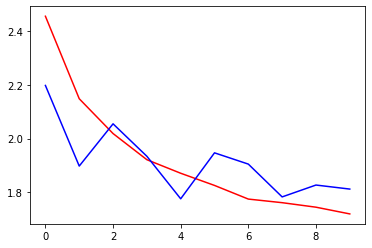

In [ ]:
# encoder = Encoder()
# decoder = Decoder(343, len(wordtoint))
# # model_states = torch.load('../input/modeltest/checkpoint7.pth', map_location=device)
# # encoder.load_state_dict(model_states["encoder_state_dict"])
# # decoder.load_state_dict(model_states["decoder_state_dict"])
# trainIters(encoder, decoder, 10, 5)

In [ ]:
# def find_file():
#     import re
#     number = 1
#     for filename in os.listdir():
#         if(len(filename) > 5 and filename[-3:] == 'pth'):
#             number = max(number, int(re.findall(r'\d+', filename)[0]))
#     return 'checkpoint' + str(number) + '.pth'
# file_to_download = find_file()

In [ ]:
# from google.colab import files
# files.download(file_to_download)

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder(343, len(wordtoint)).to(device)
model_states = torch.load('checkpoint5.pth', map_location=device)
encoder.load_state_dict(model_states["encoder_state_dict"])
decoder.load_state_dict(model_states["decoder_state_dict"])
# trainIters(encoder, decoder, 10, 5)
# trainIters(encoder, decoder, 10, 5)

31m 44s (- 285m 40s) (1 10%) 1.6490
Saving Model at Epoch: 1 with validation loss 2.313935104187453
65m 22s (- 261m 28s) (2 20%) 1.6278
99m 1s (- 231m 3s) (3 30%) 1.6304
132m 31s (- 198m 46s) (4 40%) 1.6252
165m 35s (- 165m 35s) (5 50%) 1.6415
198m 16s (- 132m 10s) (6 60%) 1.6162
231m 50s (- 99m 21s) (7 70%) 1.5953
Saving Model at Epoch: 7 with validation loss 2.26041211835389
265m 36s (- 66m 24s) (8 80%) 1.5881
299m 16s (- 33m 15s) (9 90%) 1.5743


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<mrow> <mrow>
<mo> <msub>
[ <mi>
</mo> u
<mrow> </mi>
<mo> <mi>
( n
</mo> </mi>
<mrow> </msub>
<mi> <mrow>
<mo> <mo>
</mi> =
</mrow> </mo>
<mrow> <mrow>
<mi> <mi>
</mi> o
</mrow> </mi>
</mrow> <mrow>
<EOS> <mo>
</mi> (
</mrow> </mo>
</mrow> <mrow>
</mrow> <msub>
</mrow> <mi>
</mrow> v
</mrow> </mi>
</mrow> <mi>
</mrow> n
</mrow> </mi>
</mrow> </msub>
</mrow> <mo>
</mrow> )
</mrow> </mo>
</mrow> </mrow>
</mrow> </mrow>
</mrow> </mrow>
</mrow> </mrow>
</mrow> </mrow>


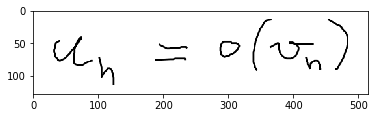

In [ ]:
%matplotlib inline
idx = 7
img, tar = get_input_pair(idx)
plt.imshow(cv2.imread(get_path("Images") + Image_file_names[idx]))
img = img.to(device)
tar = tar.to(device)
encoder = encoder.eval()
decoder = decoder.eval()
out = encoder(img).reshape(200, -1)
hid = decoder.initHidden().to(device)
start = torch.tensor([SOS_token]).to(device)
with open(get_path("MathML") + MathML_file_names[idx]) as f:
    arr = f.read().strip().split(" ")
for i in range(len(arr)):
    ans, hid, attn = decoder(start, hid, out)
    print(inttoword[int(F.softmax(ans).argmax())],arr[i])
    start = F.softmax(ans).argmax()

In [ ]:
['<mrow>',
 '<mi>',
 's',
 '</mi>',
 '<mrow>',
 '<mo>',
 '(',
 '</mo>',
 '<mrow>',
 '<mi>',
 'u',
 '</mi>',
 '<mrow>',
 '<mo>',
 ')',
 '</mo>',
 '<mrow>',
 '<mo>',
 '=',
 '</mo>',
 '<mfrac>',
 '<mrow>',
 '<mi>',
 'sin',
 '</mi>',
 '<mrow>',
 '<mo>',
 '(',
 '</mo>',
 '<mrow>',
 '<mi>',
 'u',
 '</mi>',
 '<mo>',
 ')',
 '</mo>',
 '</mrow>',
 '</mrow>',
 '</mrow>',
 '<mrow>',
 '<mi>',
 'sin',
 '</mi>',
 '<mrow>',
 '<mo>',
 '(',
 '</mo>',
 '<mrow>',
 '<mi>',
 'lambda',
 '</mi>',
 '<mo>',
 ')',
 '</mo>',
 '</mrow>',
 '</mrow>',
 '</mrow>',
 '</mfrac>',
 '</mrow>',
 '</mrow>',
 '</mrow>',
 '</mrow>',
 '</mrow>']

In [ ]:
# decoder_hidden = decoder.initHidden()
# inp_tar = torch.tensor([0])
# for i in range(len(exp_tar)+1):
#     decoder_output, decoder_hidden, decoder_attention = decoder(inp_tar, decoder_hidden, out)
#     if(i == len(exp_tar)):
#         break
#     inp_tar = exp_tar[i]

In [ ]:
# ans = 0
# for i in range(data_size):
#     img, tar = get_input_pair(i)
#     ans = max(ans, len(tar))
# ans

In [ ]:
# len(wordtoint)+1

In [ ]:
# !unzip "/content/drive/My Drive/data (1)/cleaned_mathML.zip" -d data/
# !unzip "/content/drive/My Drive/data (1)/hme_images.zip" -d data/

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip "/content/drive/My Drive/data (1)/cleaned_mathML.zip" -d data/
# !unzip "/content/drive/My Drive/data (1)/hme_images.zip" -d data/

In [ ]:
# teacher_forcing_ratio = 0.5


# def train2(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, valid=False, max_length=MAX_LENGTH):
#     encoder_optimizer.zero_grad()
#     decoder_optimizer.zero_grad()

#     target_length = target_tensor.size(0)
# #     print(input_tensor.shape)
# #     print(target_tensor.shape)
# #     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

#     loss = 0

#     encoder_outputs = encoder(input_tensor).reshape(200, -1)
    
#     decoder_input = torch.tensor([[SOS_token]], device=device)
# #     print(encoder_outputs.shape)
    
#     decoder_hidden = decoder.initHidden()

#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     loss = decode_data(target_length, decoder_input, decoder_hidden, encoder_outputs)
    
#     if(not valid):
#         loss.backward()

#         encoder_optimizer.step()
#         decoder_optimizer.step()

#     return loss.item() / target_length

In [ ]:
# def decode_data(target_length, decoder_input, decoder_hidden, encoder_outputs):
#     loss = 0
#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
#             # print(target_tensor[di], decoder_output)
#             if(int(F.softmax(ans).argmax()) != int(target_tensor[di])):
#                 loss += criterion(decoder_output, target_tensor[di])
#                 break
#             decoder_input = target_tensor[di]  # Teacher forcing

#     else:
#         # Without teacher forcing: use its own predictions as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden, decoder_attention = decoder( decoder_input, decoder_hidden, encoder_outputs)
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.squeeze().detach()  # detach from history as input

#             loss += criterion(decoder_output, target_tensor[di])
#             if decoder_input.item() == EOS_token:
#                 break
#     return loss